# Documentation of the PVprog algorithm in python

## Idea 
 Algorithm for the implementation of forecast-based battery charging for
 PV storage systems with measured value-based PV and load forecasts.

 Idea from: J. Bergner, J. Weniger, T. Tjaden,
 Forschungsgruppe Solarspeichersysteme,
 Hochschule für Technik und Wirtschaft HTW Berlin
 Version: 1.1 (5/2016)

 in python implementet by T. Tjarden, H. Hoops

## Contents: 
 This program code enables yearly simulation calculations
 of PV storage systems with two different operating strategies.
 The Focus is on comparing the following battery charging strategies:
 
 * Early battery charging: The battery storage is charged as
 charged as quickly as possible, provided that surplus PV energy is available.

 * Forecast-based battery charging: The battery storage is charged under
 load and PV forecasts, the battery storage system is only charged above a virtually
 feed-in limit.

## Variables

 a: Degree of self-sufficiency

 C_bu: usable storage capacity of the battery storage in kWh

 dt: time increment in s

 d_pv: number of past days to determine max. PV power output

 E_b(t): available battery energy content in Wh

 E_bc: battery charge in MWh/a

 E_bd: battery discharge in MWh/a

 E_ct: curtailed PV energy (curtailment) in MWh/a

 E_gf:     Grid feed-in in MWh/a

 E_gs: grid supply in MWh/a

 E_du: PV energy consumed directly (direct usage) in MWh/a

 E_ld: household electricity demand (load demand) in MWh/a

 E_pv: generated PV energy in MWh/a

 eta_batt: Efficiency of battery storage (without AC/DC conversion)

 eta_inv: Efficiency of the battery inverter

 KTF: Weather condition index

 n(t): Night indicator for period without PV power output [false,true]. 

 P_b(t): Battery power in W (positive: charge, negative: discharge)       

 P_bc(t): Battery charge power in W

 P_bd(t): Battery discharge power in W 

 P_inv: Nominal power of the battery inverter in kW

 P_d(t): differential power (PV power minus household load) in W

 P_du(t): Directly consumed PV power (direct usage) in W

 P_gf(t): grid feed-in power in W

 p_gfl: specific grid feed-in limit in kW/kWp [0...1

 P_gs(t): grid supply power in W

 P_ld(t): household electrical load (load demand) in W

 P_pv(t): PV power output in W

 p_pv(t): specific PV power output in kW/kWp [0...1]

 p_pvf(t): predicted specific PV power output in kW/kWp

 p_pvmax: maximum PV power output in W

 p_pvsel: specific PV power output in a selected period in W

 P_stc:    nominal power of the PV generator under STC test conditions in kWp

 soc(t): State of charge of the battery [0...1].

 t: Time step

 tf_past: Look-back time window in h

 tf_prog: forecast horizon in h

 time: timestamp in datenum format;

 v: adjustment loss 

 *f: forecast value (forecast)

 *min: lower limit of different sizes

 *max: upper limit of different sizes


In [1]:
import pvprog
from scipy.io import loadmat
import numpy as np
import math
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Import and define Test Data: 
Here a matlab file is read in. At the end there should be 3 equally long arrays with the data for the possible PV-power (P_pv), the load demand(P_ld) and the time (time).
After that define the Time increment (dt), 

In [2]:
#load time, electical load and p_pv
results=loadmat('../tests/pvprog_input.mat')
time1=results['time']
P_ld1=results['P_ld']
p_pv1=results['p_pv']
time=[]
P_ld=[]
p_pv=[]
minutes=15
for t in range(0,len(p_pv1),minutes): #here we only take values every 15 min. It works with everything smaller than that.
    p_pv.append(p_pv1[t:t+minutes-1].mean())
    P_ld.append(P_ld1[t:t+minutes-1].mean())
    time.append(time1[t][0])

p_pv=np.array(p_pv)
P_ld=np.array(P_ld)
time=np.array(time)
P_stc=5 # nominal power of the PV generator in kWp
C_bu=5 # usable storage capacity of the battery storage in kWh 
P_inv=2.5# nominal power of the battery inverter in kW
p_gfl=0.3# specific feed-in limit in kW/kWp (e.g. 50% feed-in limit of the KfW program)
dt=60*minutes # time increment in s
eta_batt=0.95# efficiency of the lithium battery storage (without AC/DC conversion)
eta_inv=0.94# efficiency of the battery inverter
tf_past=3# Look-back time window of the PV forecast in h 
tf_prog=15# Forecast horizon of PV and load forecast in h
P_pv=p_pv*P_stc*1000
del (P_ld1, time1 , p_pv1 , results)

In [3]:
#create class with fixed values
test=pvprog.BatProg(dt, P_stc, C_bu, P_inv, p_gfl, eta_batt, eta_inv, tf_past, tf_prog)

In [4]:
# calculation for early battery charging
P_b=np.zeros(len(time))
soc=np.zeros(len(time))
if C_bu>0:
    P_b=P_pv-P_ld 
    for t in range(1,len(time)):
        P_b[t],soc[t]=test.batt_sim(P_b[t],soc[t-1])
a,v,pf,eb=test.simu_erg(P_pv,P_ld,P_b)

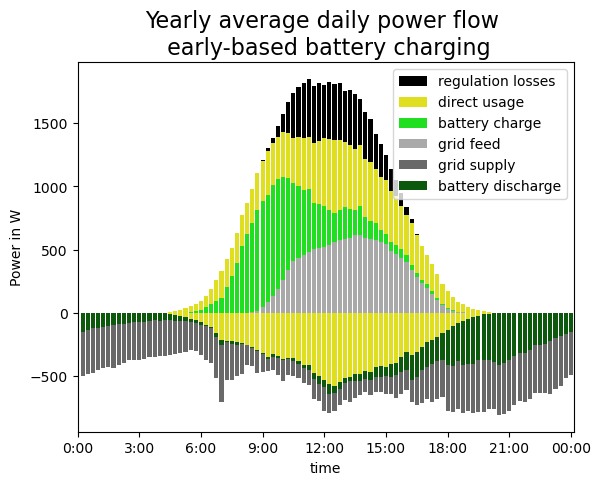

{'E_pv': 5020.245999980877,
 'E_ld': 5009.749000000001,
 'E_du': 1570.971483605976,
 'E_bc': 1350.9996165483444,
 'E_bd': 1134.0879195515824,
 'E_gf': 1327.8597239993583,
 'E_gs': 2304.689596842441,
 'E_ct': 770.4151758271989}

In [5]:
pfm= pd.DataFrame()
vars=['P_pv','P_ld','P_du','P_bc','P_bd','P_gf','P_gs','P_ct']
for i in range(0,8):
    pfm[vars[i]]=np.mean(np.reshape(pf[vars[i]],(int(1440/minutes),365),order='F'),1)
pfm['time']=range(1,int(1440/minutes+1))
pfm['P_cta']=pfm['P_ct']+pfm['P_du']+pfm['P_bc']+pfm['P_gf']
pfm['P_dua']=pfm['P_du']+pfm['P_bc']+pfm['P_gf']
pfm['P_bca']=pfm['P_bc']+pfm['P_gf']


pfm['P_gs']=-pfm['P_gs']-pfm['P_bd']-pfm['P_du']
pfm['P_bd']=-pfm['P_bd']-pfm['P_du']
pfm['P_du']=-pfm['P_du']
sns.reset_defaults()
s1 = sns.barplot(x='time',y = 'P_cta',data = pfm, color = 'black',label='regulation losses')
s2 = sns.barplot(x='time',y = 'P_dua', data = pfm, color = 'yellow',label='direct usage')
s3 = sns.barplot(x='time',y = 'P_bca', data = pfm, color = 'lime',label='battery charge')
s4 = sns.barplot(x='time',y = 'P_gf', data = pfm, color = 'darkgrey',label='grid feed')
s5 = sns.barplot(x='time',y = 'P_gs', data = pfm, color = 'dimgrey',label='grid supply')
s6 = sns.barplot(x='time',y = 'P_bd', data = pfm, color = 'darkgreen',label='battery discharge')
s7 = sns.barplot(x='time',y = 'P_du', data = pfm, color = 'yellow')

plt.title('Yearly average daily power flow \n early-based battery charging', fontsize=16)
s1.legend()
#add axis titles
plt.xticks(range(-1,int(1440/minutes),int(1440/minutes/8)),['0:00','3:00','6:00','9:00','12:00','15:00','18:00','21:00','00:00'])
plt.ylabel('Power in W')
plt.show()
eb

In [6]:
#calculation for forcast-based battery charging
P_b=np.zeros(len(time))
soc=np.zeros(len(time))
P_pvf=test.prog4pv(time,P_pv)
P_ldf,time_f = test.prog4ld(time,P_ld)
P_d=P_pv-P_ld
P_df=P_pvf-P_ldf
P_bf = 0
P_dfsel = 0
if C_bu>0:
    for t in range(1,len(time)):
        t_fsel=math.floor(t*dt/900)
        if (sum(P_pv[t:np.minimum(t+int(900/dt)+1,len(P_pv))])>0)&(time[t]==time_f[t_fsel]):
            P_bf,P_dfsel=test.batt_prog(t,P_df,soc)
        P_b[t]=test.err_ctrl(t,P_d,P_dfsel,P_bf)
        P_b[t],soc[t]=test.batt_sim(P_b[t],soc[t-1]) 
a,v,pf,eb=test.simu_erg(P_pv,P_ld,P_b)

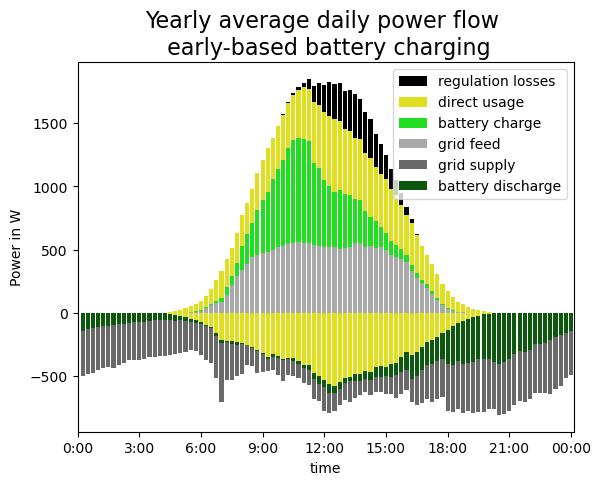

{'E_pv': 5020.245999980877,
 'E_ld': 5009.749000000001,
 'E_du': 1570.971483605976,
 'E_bc': 1313.5703504462656,
 'E_bd': 1102.637223571604,
 'E_gf': 1716.4355548425176,
 'E_gs': 2336.14029282242,
 'E_ct': 419.2686110861191}

In [7]:
pfm= pd.DataFrame()
vars=['P_pv','P_ld','P_du','P_bc','P_bd','P_gf','P_gs','P_ct']
for i in range(0,8):
    pfm[vars[i]]=np.mean(np.reshape(pf[vars[i]],(int(1440/minutes),365),order='F'),1)
pfm['time']=range(1,int(1440/minutes+1))
pfm['P_cta']=pfm['P_ct']+pfm['P_du']+pfm['P_bc']+pfm['P_gf']
pfm['P_dua']=pfm['P_du']+pfm['P_bc']+pfm['P_gf']
pfm['P_bca']=pfm['P_bc']+pfm['P_gf']


pfm['P_gs']=-pfm['P_gs']-pfm['P_bd']-pfm['P_du']
pfm['P_bd']=-pfm['P_bd']-pfm['P_du']
pfm['P_du']=-pfm['P_du']
sns.reset_defaults()
s1 = sns.barplot(x='time',y = 'P_cta',data = pfm, color = 'black',label='regulation losses')
s2 = sns.barplot(x='time',y = 'P_dua', data = pfm, color = 'yellow',label='direct usage')
s3 = sns.barplot(x='time',y = 'P_bca', data = pfm, color = 'lime',label='battery charge')
s4 = sns.barplot(x='time',y = 'P_gf', data = pfm, color = 'darkgrey',label='grid feed')
s5 = sns.barplot(x='time',y = 'P_gs', data = pfm, color = 'dimgrey',label='grid supply')
s6 = sns.barplot(x='time',y = 'P_bd', data = pfm, color = 'darkgreen',label='battery discharge')
s7 = sns.barplot(x='time',y = 'P_du', data = pfm, color = 'yellow')

plt.title('Yearly average daily power flow \n early-based battery charging', fontsize=16)
s1.legend()
#add axis titles
plt.xticks(range(-1,int(1440/minutes),int(1440/minutes/8)),['0:00','3:00','6:00','9:00','12:00','15:00','18:00','21:00','00:00'])
plt.ylabel('Power in W')
plt.show()
eb